In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
from scipy.interpolate import griddata
from torch.utils.data import DataLoader, Dataset

In [2]:
# 生成随机一个U带有m个点，y采样P个
def generate_bcs_training_data(m=100, P=100):
    r = np.random.uniform()
    fn_theta = lambda theta:  np.hstack([r * np.cos(theta), r * np.sin(theta)])
    theta = np.linspace(0, 2 * np.pi, m)

    u =  np.array(list(map(fn_theta, theta))).reshape(1, -1)  # shape = (1, 2m)   (x1, y1, x2, y2, ...) 
    # Fixed sensors
    theta = np.linspace(0, 2 * np.pi, P)
    y1 = r * np.cos(theta)[:, None]
    y2 = r * np.sin(theta)[:, None]
    y =  np.hstack([y1, y2])  # shape = (P, 2)
    # Tile inputs
    u = np.tile(u, (P, 1))  # shape = (P, 2m) in this example P = m
    s = np.zeros((P, 1))

    return u, y, s 

# Geneate training data corresponding to PDE residual
def generate_res_training_data(m=100, P=100):
    r = np.random.uniform()
    fn_theta = lambda theta:  np.hstack([r * np.cos(theta), r * np.sin(theta)])
    theta = np.linspace(0, 2 * np.pi, m)

    u =  np.array(list(map(fn_theta, theta))).reshape(1, -1)  # shape = (1, 2m)   (x1, y1, x2, y2, ...) 
    # Collocation points in [-1, 1] x [-1, 1]
    y = - 1 + 2 * np.random.random((P,2))
    
    # Tile inputs
    u = np.tile(u, (P,1))  # shape = (P, 2m) 
    s = np.zeros((P, 1))

    return u, y, s 

# Geneate test data 
def generate_test_data(m=100, P=100, R = None):
    if R != None:
        r = R
    else:
        r = np.random.uniform()
    fn_theta = lambda theta:  np.hstack([r * np.cos(theta), r * np.sin(theta)])
    theta = np.linspace(0, 2 * np.pi, m)
    u =  np.array(list(map(fn_theta, theta))).reshape(1, -1)  # shape = (1, 2m)   (x1, y1, x2, y2, ...) 

    y1 = np.linspace(-1,1, P)
    y2 = np.linspace(-1,1, P)

    y1, y2 = np.meshgrid(y1, y2)
    y = np.hstack((y1.flatten()[:, None], y2.flatten()[:, None]))  # shape = (P, 2)

    # Tile inputs
    u = np.tile(u, (P**2, 1))  # shape = (P, 2m) in this example P = m

    # Exact solution
    def signed_dist(y1, y2):
      dist = np.sqrt(y1**2 +y2**2) - r   # 圆形边界的解析解
      return dist

    s = signed_dist(y[:,0:1], y[:,1:2])
    return r, u, y, s 
     

In [3]:
m = 100
N_train = 1000
N_r_train = 1000

U,Y,S=[],[],[]
for _ in range(N_train):
    u,y,s=generate_bcs_training_data()
    U.append(u)
    Y.append(y)
    S.append(s)
U_r,Y_r,S_r=[],[],[]
for _ in range(N_r_train):
    u_r,y_r,s_r=generate_res_training_data(P=1000)
    U_r.append(u_r)
    Y_r.append(y_r)
    S_r.append(s_r)
U = np.vstack(U)
Y = np.vstack(Y)
S = np.vstack(S)
U_r = np.vstack(U_r)
Y_r = np.vstack(Y_r)
S_r = np.vstack(S_r)
print(U.shape,Y.shape,S.shape)
print(U_r.shape,Y_r.shape,S_r.shape)

(100000, 200) (100000, 2) (100000, 1)
(1000000, 200) (1000000, 2) (1000000, 1)


In [4]:
class BranchNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(BranchNetwork, self).__init__()
        self.activation = nn.Tanh()
        self.encodeU = nn.Linear(input_dim, hidden_channle)
        self.encodeV = nn.Linear(input_dim, hidden_channle)
        self.IN = nn.Linear(input_dim, hidden_channle)
        self.weight1 = nn.Linear(hidden_channle, hidden_channle)
        self.weight2 = nn.Linear(hidden_channle, hidden_channle)
        self.weight3 = nn.Linear(hidden_channle, hidden_channle)
        self.weight4 = nn.Linear(hidden_channle, hidden_channle)
            
        self.out = nn.Linear(hidden_channle, output_dim)
    def forward(self, x):
        U = self.activation(self.encodeU(x))
        V = self.activation(self.encodeV(x))
        H1 = self.activation(self.IN(x))
        
        Z1 = self.activation(self.weight1(H1))
        H2 = (1 - Z1) * U + Z1 * V
        
        Z2 = self.activation(self.weight2(H2))
        H3 = (1 - Z2) * U + Z2 * V
        
        Z3 = self.activation(self.weight3(H3))
        H4 = (1 - Z3) * U + Z3 * V
        
        Z4 = self.activation(self.weight4(H4))
        H5 = (1 - Z4) * U + Z4 * V
        
        x = self.out(H5)
        return x

class TrunkNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(TrunkNetwork, self).__init__()
        self.activation = nn.Tanh()
        self.encodeU = nn.Linear(input_dim, hidden_channle)
        self.encodeV = nn.Linear(input_dim, hidden_channle)
        self.IN = nn.Linear(input_dim, hidden_channle)
        self.weight1 = nn.Linear(hidden_channle, hidden_channle)
        self.weight2 = nn.Linear(hidden_channle, hidden_channle)
        self.weight3 = nn.Linear(hidden_channle, hidden_channle)
        self.weight4 = nn.Linear(hidden_channle, hidden_channle)
            
        self.out = nn.Linear(hidden_channle, output_dim)
    def forward(self, x):
        U = self.activation(self.encodeU(x))
        V = self.activation(self.encodeV(x))
        H1 = self.activation(self.IN(x))
        
        Z1 = self.activation(self.weight1(H1))
        H2 = (1 - Z1) * U + Z1 * V
        
        Z2 = self.activation(self.weight2(H2))
        H3 = (1 - Z2) * U + Z2 * V
        
        Z3 = self.activation(self.weight3(H3))
        H4 = (1 - Z3) * U + Z3 * V
        
        Z4 = self.activation(self.weight4(H4))
        H5 = (1 - Z4) * U + Z4 * V
        
        x = self.out(H5)
        return x
'''
class BranchNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(BranchNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self, x):
        x=self.net(x)
        return x

class TrunkNetwork(nn.Module):
    def __init__(self, input_dim, hidden_channle, output_dim):
        super(TrunkNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, hidden_channle), nn.Tanh(),
            nn.Linear(hidden_channle, output_dim)
        )
    def forward(self, x):
        x=self.net(x)
        return x
'''
class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_channle, output_dim):
        super(DeepONet, self).__init__()
        self.branch_net = BranchNetwork(branch_input_dim, hidden_channle, output_dim)
        self.trunk_net = TrunkNetwork(trunk_input_dim, hidden_channle, output_dim)

    def forward(self, branch_input, trunk_input):
        branch_output = self.branch_net(branch_input)
        trunk_output = self.trunk_net(trunk_input)
        
        s = torch.sum(branch_output * trunk_output, axis=1)
        return s.view(-1,1)

In [5]:
def Res_loss(u_r, y1, y2, s_r):
    s_pred = model(u_r, torch.hstack((y1,y2)))
    s_y1 = torch.autograd.grad(s_pred, y1, torch.ones_like(s_pred), retain_graph=True, create_graph=True)[0]
    s_y2 = torch.autograd.grad(s_pred, y2, torch.ones_like(s_pred), retain_graph=True, create_graph=True)[0]
    f = s_y1**2 + s_y2**2 - 1
    return torch.mean(f**2)
    
def Bcs_loss(u, y, s):
    s_pred = model(u, y)
    return torch.mean(s_pred**2)

def Loss(u, y, s, u_r, y_r, s_r):
    y1 = y_r[:,0].reshape(-1,1)
    y2 = y_r[:,1].reshape(-1,1)
    res_loss = Res_loss(u_r, y1, y2, s_r)
    bcs_loss = Bcs_loss(u, y, s)
    loss = res_loss + bcs_loss
    return loss, res_loss, bcs_loss

def get_data(u, y, s, u_r, y_r, s_r, batch_size=10000, batch_size_r=20000):
    indices = torch.randint(0, u.size(0), (batch_size,))
    indices_r = torch.randint(0, u_r.size(0), (batch_size_r,))
    u = u[indices,:]
    y = y[indices,:]
    s = s[indices,:]
    u_r = u_r[indices_r,:]
    y_r = y_r[indices_r,:]
    s_r = s_r[indices_r,:]
    return u, y, s, u_r, y_r, s_r

loadding model!
[Epoch 1/100] [loss: 0.11585748940706253]
[Epoch 2/100] [loss: 0.06514643877744675]
[Epoch 3/100] [loss: 0.04018081724643707]
[Epoch 4/100] [loss: 0.025326188653707504]
[Epoch 5/100] [loss: 0.014836064539849758]
[Epoch 6/100] [loss: 0.010005897842347622]
[Epoch 7/100] [loss: 0.008994128555059433]
[Epoch 8/100] [loss: 0.006277276668697596]
[Epoch 9/100] [loss: 0.005053647793829441]
[Epoch 10/100] [loss: 0.005225699860602617]
[Epoch 11/100] [loss: 0.0039805578999221325]
[Epoch 12/100] [loss: 0.003861623350530863]
[Epoch 13/100] [loss: 0.0033013862557709217]
[Epoch 14/100] [loss: 0.002995177172124386]
[Epoch 15/100] [loss: 0.0029020309448242188]
[Epoch 16/100] [loss: 0.0025217391084879637]
[Epoch 17/100] [loss: 0.002220692578703165]
[Epoch 18/100] [loss: 0.0022772164084017277]
[Epoch 19/100] [loss: 0.0018388342577964067]
[Epoch 20/100] [loss: 0.0018678848864510655]
[Epoch 21/100] [loss: 0.001778595382347703]
[Epoch 22/100] [loss: 0.0018041155999526381]
[Epoch 23/100] [loss

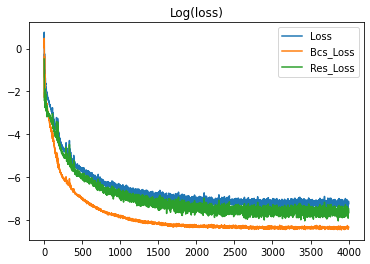

In [6]:
u = torch.tensor(U, dtype=torch.float32, requires_grad=True)
y = torch.tensor(Y, dtype=torch.float32, requires_grad=True)
s = torch.tensor(S, dtype=torch.float32, requires_grad=True)
u_r = torch.tensor(U_r, dtype=torch.float32, requires_grad=True)
y_r = torch.tensor(Y_r, dtype=torch.float32, requires_grad=True)
s_r = torch.tensor(S_r, dtype=torch.float32, requires_grad=True)

model = DeepONet(2 * m, 2, 100, 100)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
epochs = 100
Iters = 40
Losses = []
Res_Loss = []
Bcs_Loss = []
file_name = 'C:\\Users\\Fan\\JupyterFile\\DeepLearning\\PINNs\\piDeepONet_EikonalRquation_circle.pkl'
loadding = True
if loadding and os.path.exists(file_name) and os.path.isfile(file_name):
    try:
        model.load_state_dict(torch.load(file_name))
        print('loadding model!')
    except:
        print('loadding error!')
for epoch in range(epochs):
    for Iter in range(Iters):
        optimizer.zero_grad()
        loss, res_loss, bcs_loss = Loss(*get_data(u, y, s, u_r, y_r, s_r))
        loss.backward()
        Losses.append(loss.item())
        Res_Loss.append(res_loss.item())
        Bcs_Loss.append(bcs_loss.item())
        optimizer.step()
    scheduler.step()
    print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    if epoch % 10 == 0:
        torch.save(model.state_dict(), file_name)
plt.title('Log(loss)')
plt.plot(np.log(Losses), label = 'Loss')
plt.plot(np.log(Bcs_Loss), label = 'Bcs_Loss')
plt.plot(np.log(Res_Loss), label = 'Res_Loss')
plt.legend()
plt.show()

(10000, 200) (10000, 2) (10000, 1)
R: 0.433659994606713  error_s: 0.01834999956190586  error_d: 0.08037377148866653


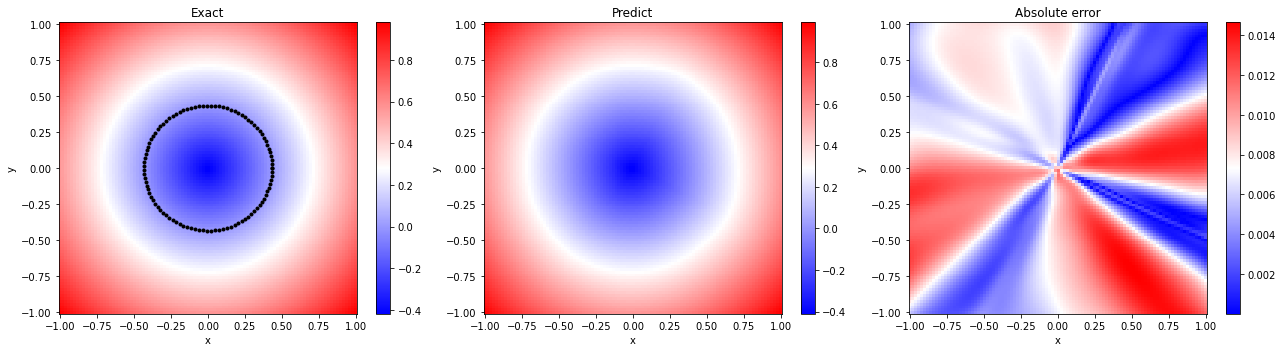

(10000, 200) (10000, 2) (10000, 1)
R: 0.5435203038836689  error_s: 0.010690080001950264  error_d: 0.03941696882247925


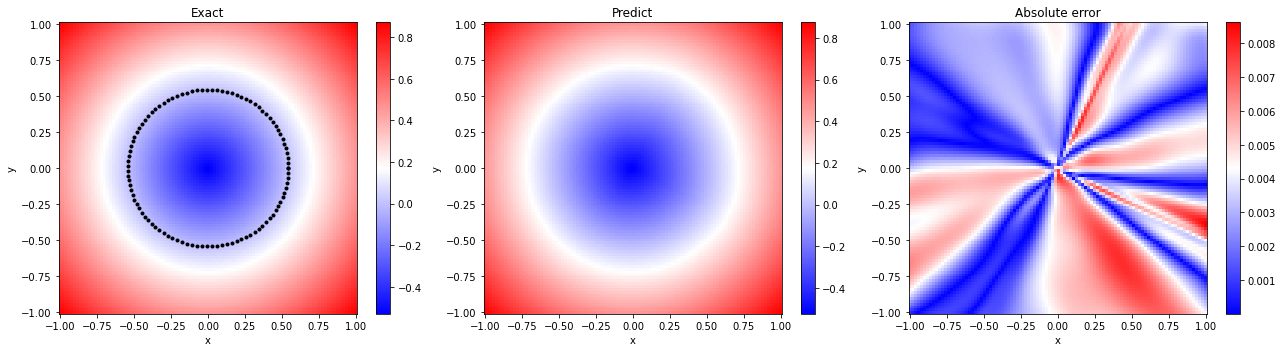

(10000, 200) (10000, 2) (10000, 1)
R: 0.042195294822020224  error_s: 1.2006704807281494  error_d: 0.2904006540775299


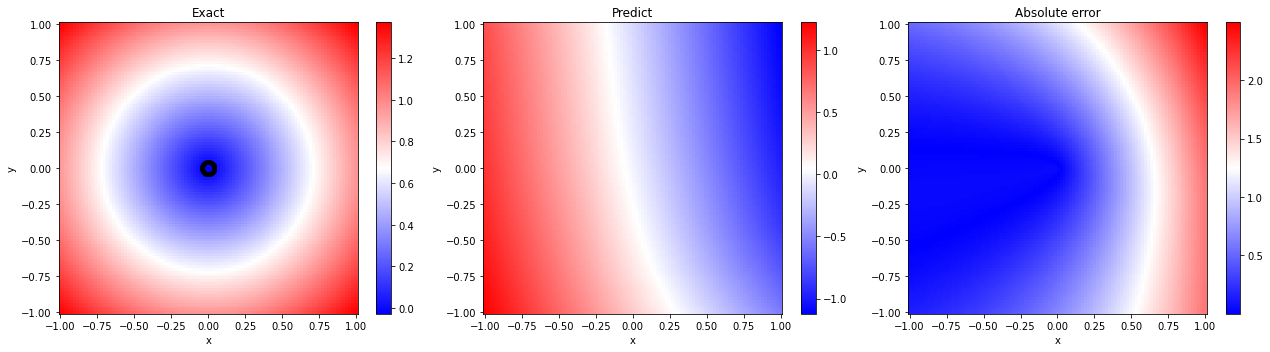

In [7]:
def test(RR = None):
    N_t_train = 1
    R,U_t,Y_t,S_t=[],[],[],[]
    for _ in range(N_t_train):
        r,u_t,y_t,s_t=generate_test_data(R = RR)
        R.append(r)
        U_t.append(u_t)
        Y_t.append(y_t)
        S_t.append(s_t)
    U_t = np.vstack(U_t)
    Y_t = np.vstack(Y_t)
    S_t = np.vstack(S_t)
    R = np.array(R)
    print(U_t.shape,Y_t.shape,S_t.shape)

    u_test = torch.tensor(U_t, dtype=torch.float32, requires_grad=True)
    y_test = torch.tensor(Y_t, dtype=torch.float32, requires_grad=True)
    s_test = torch.tensor(S_t, dtype=torch.float32, requires_grad=True)
    s_pred = model(u_test, y_test)
    
    idx = 0
    index = np.arange(idx * 10000,(idx + 1) * 10000)
    theta = np.linspace(0, 2* np.pi, 100)

    u1 = R[idx] * np.cos(theta)[:, None]
    u2 = R[idx] * np.sin(theta)[:, None]
    
    u1_test = torch.tensor(u1.reshape(-1,1), dtype=torch.float32, requires_grad=True)
    u2_test = torch.tensor(u2.reshape(-1,1), dtype=torch.float32, requires_grad=True)
    s_b_pre = model(u_test[:u1_test.shape[0],:], torch.hstack((u1_test, u2_test)))
    
    u_test = u_test.detach().numpy()
    y_test = y_test.detach().numpy()
    s_test = s_test.detach().numpy()
    s_pred = s_pred.detach().numpy()
    s_b_pre = s_b_pre.detach().numpy()
    
    error_s = np.linalg.norm(s_test[index, :] - s_pred[index, :]) / np.linalg.norm(s_test[index, :])
    error_d = np.linalg.norm(s_b_pre)
    print(f'R: {R[0]}  error_s: {error_s}  error_d: {error_d}')

    y1 = np.linspace(-1,1, 100)
    y2 = np.linspace(-1,1, 100)

    y1, y2 = np.meshgrid(y1, y2)
    y_star = np.hstack((y1.flatten()[:, None], y2.flatten()[:, None]))

    S_star = griddata(y_star, s_test[index, :].flatten(), (y1, y2), method='cubic')
    S_pred = griddata(y_star, s_pred[index, :].flatten(), (y1, y2), method='cubic')

    plt.figure(figsize=(18,5))
    plt.subplot(1,3,1)
    plt.pcolor(y1, y2, S_star, cmap='bwr')
    plt.plot(u1, u2, '.', color='black')
    plt.title('Exact')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    plt.tight_layout()

    plt.subplot(1,3,2)
    plt.pcolor(y1, y2, S_pred, cmap='bwr')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Predict')
    plt.tight_layout()

    plt.subplot(1,3,3)
    plt.pcolor(y1, y2, np.abs(S_pred- S_star), cmap='bwr')
    plt.colorbar()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Absolute error')
    plt.tight_layout()
    plt.show()
test()
test()
test()

(10000, 200) (10000, 2) (10000, 1)
R: 0.0  error_s: 1.213040828704834  error_d: 0.04020538926124573


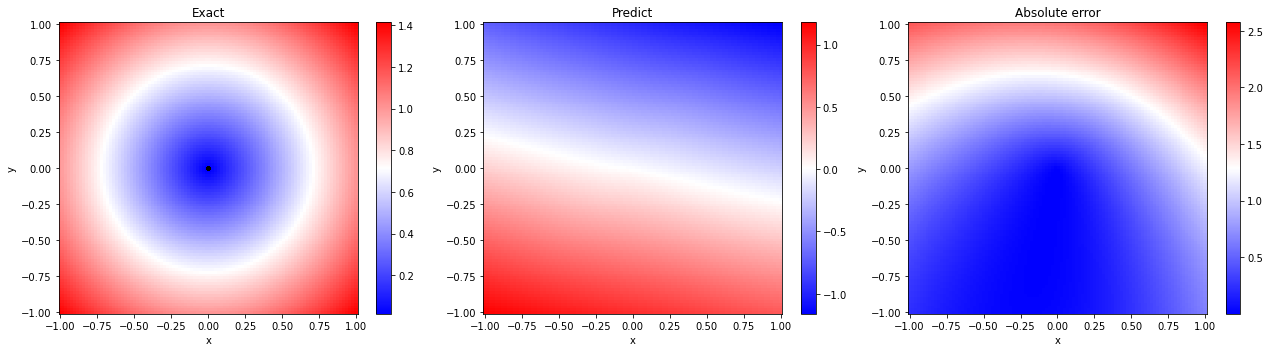

(10000, 200) (10000, 2) (10000, 1)
R: 0.1111111111111111  error_s: 0.29961976408958435  error_d: 0.2824905216693878


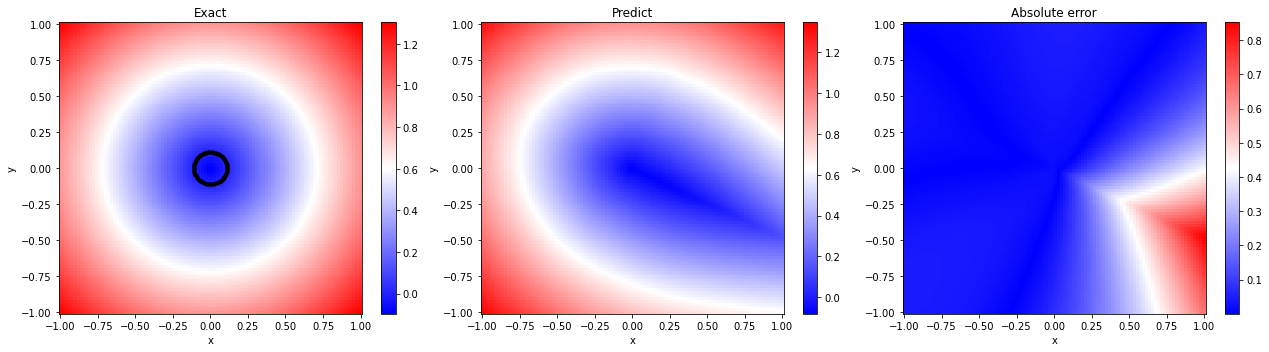

(10000, 200) (10000, 2) (10000, 1)
R: 0.2222222222222222  error_s: 0.01918712630867958  error_d: 0.06013655290007591


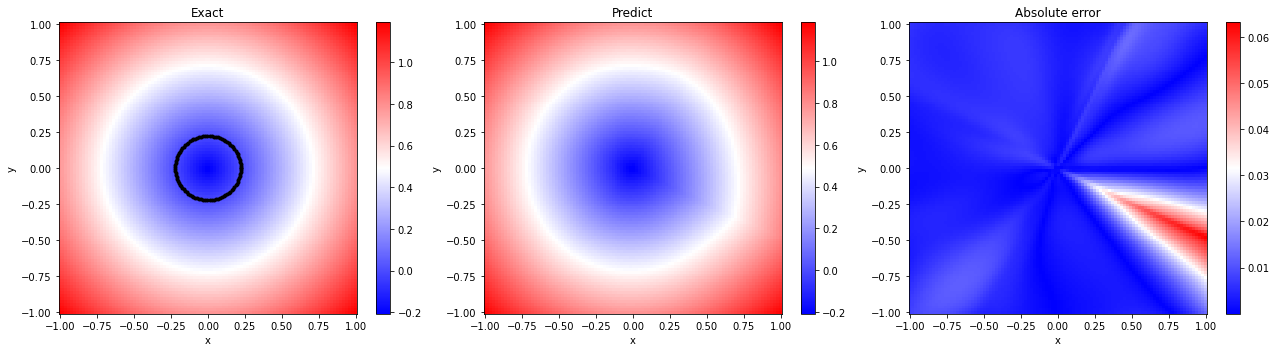

(10000, 200) (10000, 2) (10000, 1)
R: 0.3333333333333333  error_s: 0.011067827232182026  error_d: 0.04929831624031067


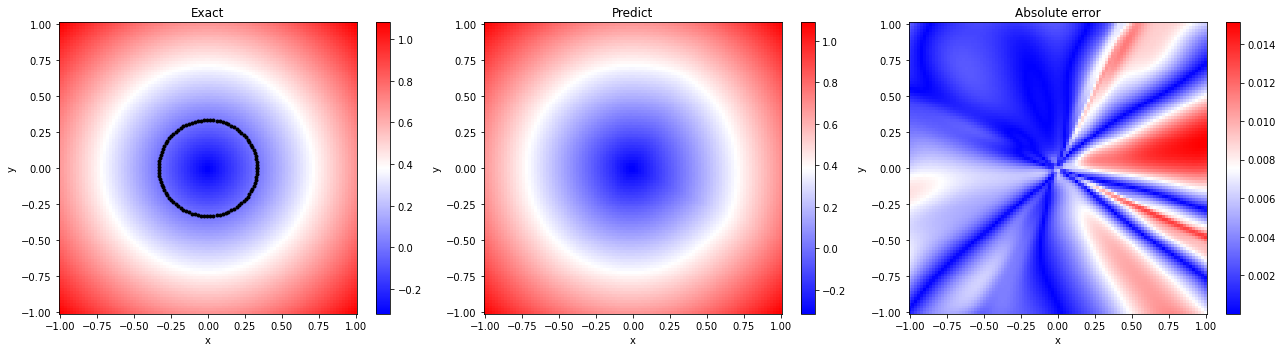

(10000, 200) (10000, 2) (10000, 1)
R: 0.4444444444444444  error_s: 0.01829114928841591  error_d: 0.07905280590057373


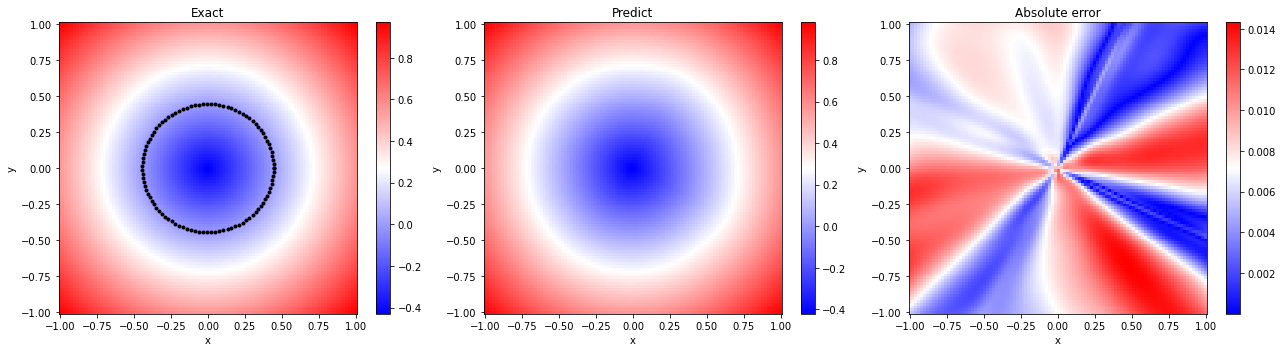

(10000, 200) (10000, 2) (10000, 1)
R: 0.5555555555555556  error_s: 0.009900742210447788  error_d: 0.03535885736346245


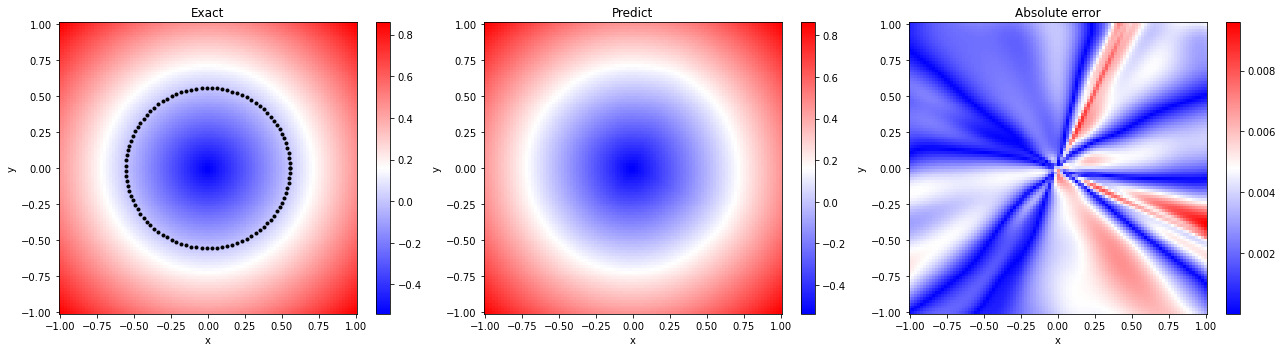

(10000, 200) (10000, 2) (10000, 1)
R: 0.6666666666666666  error_s: 0.0221359021961689  error_d: 0.06618386507034302


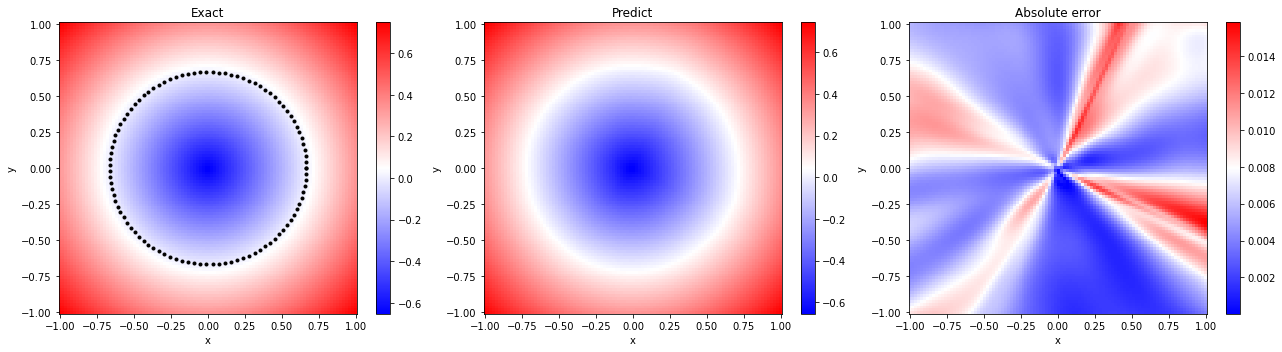

(10000, 200) (10000, 2) (10000, 1)
R: 0.7777777777777777  error_s: 0.026649905368685722  error_d: 0.07587997615337372


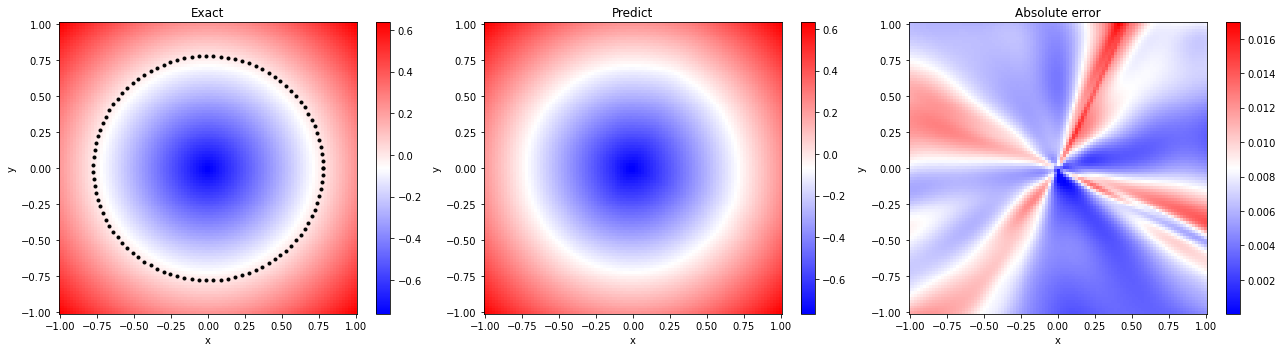

(10000, 200) (10000, 2) (10000, 1)
R: 0.8888888888888888  error_s: 0.009897219948470592  error_d: 0.030022362247109413


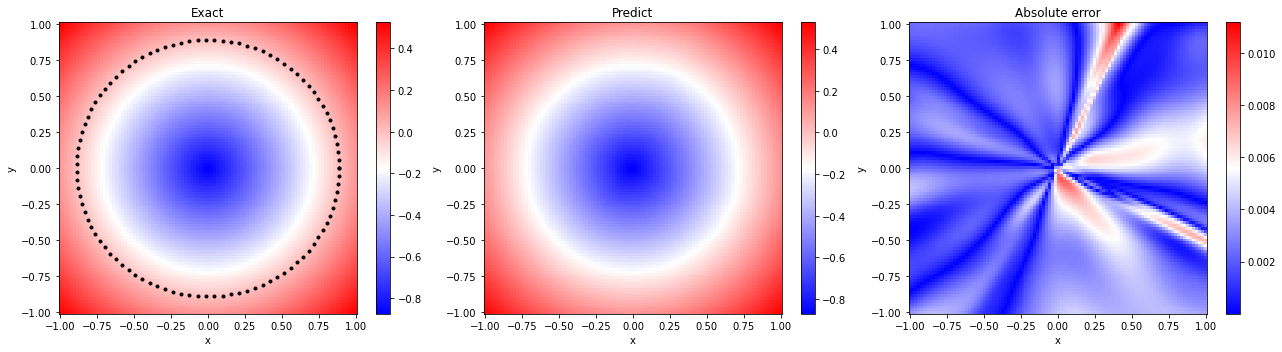

(10000, 200) (10000, 2) (10000, 1)
R: 1.0  error_s: 0.05680069699883461  error_d: 0.2085992842912674


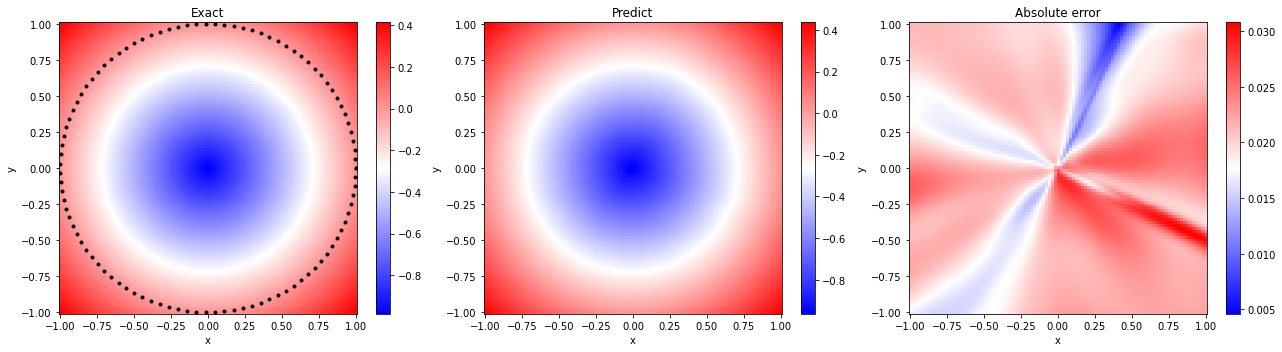

In [8]:
R = np.linspace(0,1,10)
for r in R:
    test(RR=r)